In [1]:
import findspark
findspark.init() 
from pyspark import SparkContext
sc= SparkContext("local","Week7")

In [2]:
from pyspark.sql import SparkSession
spark= SparkSession.builder.getOrCreate()

In [3]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [4]:
noCol_data= spark.read.option("InferSchema",True).option("header",False).csv("kddcup.data_10_percent_corrected.csv")

In [5]:
cols= ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
        'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
        'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
        'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
        'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
        'label' 
]

In [6]:
len(cols)

42

In [7]:
noCol_data.count()

494021

In [8]:
df= noCol_data.toDF(*cols)
df.show(3)

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_hos

In [9]:
df.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true

In [10]:
noOfLabels=(df.groupBy(col('label')).count()).count()

### dropping non numeric, unnecessary columns

In [12]:
numeric_only= df.drop('protocol_type', 'service', 'flag')
print(f"No of columns in after the drop: {len(numeric_only.columns)}")

No of columns in after the drop: 39


### feature vector and kmeans instance creation

In [13]:
from pyspark.ml.feature import VectorAssembler , StandardScaler
from pyspark.ml.clustering import KMeans

In [14]:
feat_input=numeric_only.columns
#feat_input[:-1]

In [15]:
assembler= VectorAssembler(inputCols=feat_input[:-1], outputCol='features')
assembler

VectorAssembler_d97e3718a6a4

In [16]:
kmeans_instance= KMeans(featuresCol='features', predictionCol='clusters', k=5)

### Pipeline 

In [17]:
from pyspark.ml import Pipeline

In [18]:
pipe= Pipeline(stages=[assembler, kmeans_instance])

In [19]:
model= pipe.fit(numeric_only)

In [20]:
kmodel= model.transform(numeric_only)

In [21]:
model.stages[1]

KMeansModel: uid=KMeans_c0d08c2b58c6, k=5, distanceMeasure=euclidean, numFeatures=38

In [22]:
model.stages[-1].clusterCenters()

[array([4.73602651e+01, 9.02036844e+02, 6.61185042e+02, 4.45421673e-05,
        6.43431853e-03, 1.41725078e-05, 3.42002859e-02, 1.45774366e-04,
        1.48108780e-01, 1.01778852e-02, 1.09330774e-04, 3.23943035e-05,
        1.13359816e-02, 1.08318452e-03, 1.09330774e-04, 1.00827270e-03,
        0.00000000e+00, 0.00000000e+00, 1.38688112e-03, 3.32357305e+02,
        2.92969701e+02, 1.76721312e-01, 1.76643404e-01, 5.74434011e-02,
        5.77287544e-02, 7.91506801e-01, 2.09807375e-02, 2.89962018e-02,
        2.32508238e+02, 1.88698211e+02, 7.53785295e-01, 3.09055625e-02,
        6.01906324e-01, 6.66970363e-03, 1.76787173e-01, 1.76474852e-01,
        5.81274675e-02, 5.74233571e-02]),
 array([2.0000000e+00, 6.9337564e+08, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 

In [23]:
kmodel.groupBy("clusters").count().show()

+--------+------+
|clusters| count|
+--------+------+
|       1|     1|
|       3|    23|
|       4|    24|
|       2|    59|
|       0|493914|
+--------+------+



In [24]:
kmodel.groupBy("clusters","label").count().orderBy("clusters", "count",ascending=False).show(50)

+--------+----------------+------+
|clusters|           label| count|
+--------+----------------+------+
|       4|         normal.|    23|
|       4|    warezclient.|     1|
|       3|    warezmaster.|    15|
|       3|         normal.|     8|
|       2|    warezclient.|    59|
|       1|      portsweep.|     1|
|       0|          smurf.|280790|
|       0|        neptune.|107201|
|       0|         normal.| 97247|
|       0|           back.|  2203|
|       0|          satan.|  1589|
|       0|        ipsweep.|  1247|
|       0|      portsweep.|  1039|
|       0|       teardrop.|   979|
|       0|    warezclient.|   960|
|       0|            pod.|   264|
|       0|           nmap.|   231|
|       0|   guess_passwd.|    53|
|       0|buffer_overflow.|    30|
|       0|           land.|    21|
|       0|           imap.|    12|
|       0|        rootkit.|    10|
|       0|     loadmodule.|     9|
|       0|      ftp_write.|     8|
|       0|       multihop.|     7|
|       0|    warezm

### function to optimize

In [25]:
from pyspark.ml.feature import VectorAssembler , StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline

In [26]:
df.show(3)

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_hos

In [27]:
data= df.alias("df2")

In [28]:
data.show(2)

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_hos

In [29]:
def clustering_score(k):
    numeric_only_func= data.drop('protocol_type', 'service', 'flag')

    assembler_func= VectorAssembler(inputCols=feat_input[:-1], outputCol='features')   

    # to remove the dominance of large scale features we need to scale down to a standard value for all the features
    scaler= StandardScaler(inputCol='features', outputCol='scaled_features', withMean=False, withStd=True)

    kmeans= KMeans(featuresCol="scaled_features", predictionCol='cluster',k=k,
                   tol=1e-5, maxIter=50
                   )
    pipe_func= Pipeline(stages=[assembler_func,scaler,kmeans])
    model= pipe_func.fit(numeric_only_func)
    return model, model.stages[-1].summary.trainingCost

In [30]:
costs=  []
ks= []
for k in range(10,131,10):
    ks.append(k)
    model_f, cost_f= clustering_score(k)
    costs.append(cost_f)


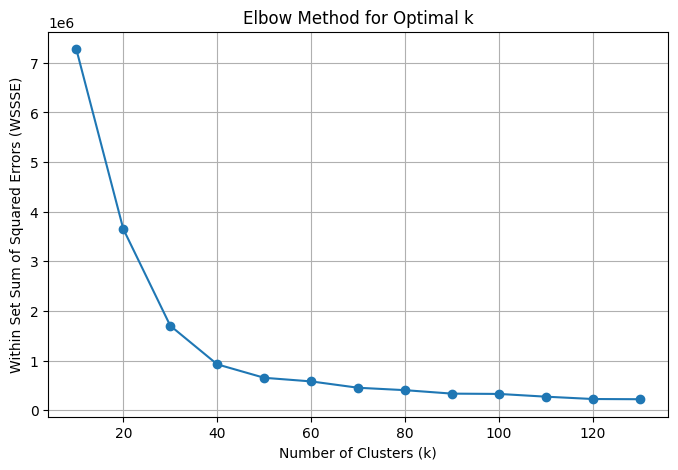

In [31]:
# plot elbow curve
plt.figure(figsize=(8,5))
plt.plot(ks, costs, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within Set Sum of Squared Errors (WSSSE)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

### Includng the categorical cols

In [32]:
import matplotlib.pyplot as plt

In [33]:
data2= df.alias("data2")
#data2.show(2)

In [34]:
def encoding_pipeline(input_col):
    indexer = StringIndexer(inputCol=input_col, outputCol=input_col+"_indexed", handleInvalid="keep")
    encoder = OneHotEncoder(inputCol=input_col+"_indexed", outputCol=input_col+"_vector")
    #pp= Pipeline(stages=[indexer, encoder]  )
    return [indexer, encoder], input_col+"_vector"

In [35]:
def clustering_score(df, k):
    # encoding pipelines for dropped categorical columns
    protocol_stages, prot_col = encoding_pipeline("protocol_type")
    service_stages, service_col = encoding_pipeline("service")
    flag_stages, flag_col = encoding_pipeline("flag")

    # assemble all feature columns
    assemble_cols = [c for c in df.columns if c not in ["protocol_type", "service", "flag", "label"]] \
                    + [prot_col, service_col, flag_col]

    assembler_func = VectorAssembler(inputCols=assemble_cols, outputCol='features')

    # scaling features
    scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=False, withStd=True)

    # kMeans model
    kmeans = KMeans(featuresCol="scaled_features", predictionCol='cluster', k=k, tol=1e-5, maxIter=50)

    # main pipeline
    pipe_func = Pipeline(stages=protocol_stages + service_stages + flag_stages + [assembler_func, scaler, kmeans])

    model = pipe_func.fit(df)

    return model, model.stages[-1].summary.trainingCost

In [36]:
costs = []
#k_values = [2, 3, 4, 5, 6]

for k in range(60,221,10):
    model, cost = clustering_score(data2, k)
    costs.append(cost)
    print(f"k={k}, cost={cost}")


k=60, cost=18959246.25944109
k=70, cost=14818690.33547038
k=80, cost=10526256.380398247
k=90, cost=8059469.890938333
k=100, cost=5165538.411608993
k=110, cost=2287689.2717928705
k=120, cost=1582686.9492007203
k=130, cost=1387072.220509692
k=140, cost=1176907.0935055206
k=150, cost=968028.3544666193
k=160, cost=899102.023333649
k=170, cost=862196.3439892879
k=180, cost=737694.0330731606
k=190, cost=740406.5575205687
k=200, cost=661402.2479446323
k=210, cost=601468.9568873479
k=220, cost=583036.232969626


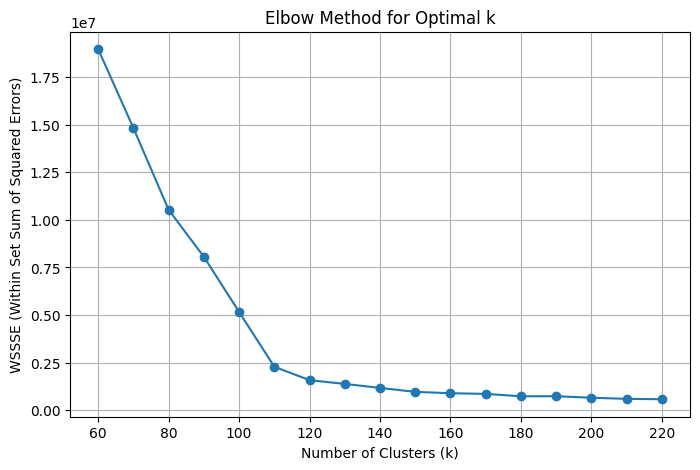

In [37]:
k_values = list(range(60, 221, 10))

plt.figure(figsize=(8,5))
plt.plot(k_values, costs, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WSSSE (Within Set Sum of Squared Errors)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()


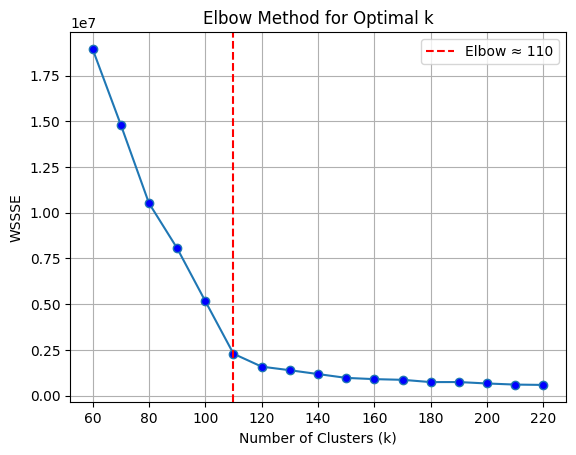

In [38]:
k_values = list(range(60, 221, 10))

plt.plot(k_values, costs, 'o-', markerfacecolor='blue')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSSSE')
plt.grid(True)

# mark elbow
plt.axvline(x=110, color='red', linestyle='--', label='Elbow ≈ 110')
plt.legend()
plt.show()


In [39]:
model_fin, cost_fin= clustering_score(data2,110)

In [40]:
kmod= model_fin.transform(data2)

In [41]:
kmod.show(2)

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+---------------------+--------------------+---------------+--------------+------------+--------------+--------------------+--------------------+-------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_

In [42]:
kmod.groupBy('cluster').count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|     31|   44|
|     85|   17|
|     65|  380|
|     53|  435|
|     78|  110|
|    108|    1|
|     34|    1|
|    101|   11|
|     81|    3|
|     28|  104|
|     76|   21|
|     26|  102|
|     27|    7|
|     44|26861|
|    103|   90|
|     12|    1|
|     91|  114|
|     22|  106|
|     93|  102|
|     47|  106|
+-------+-----+
only showing top 20 rows



In [43]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [44]:
# Compute counts per cluster-label combination
df_ent = kmod.groupBy('cluster', 'label').count()
df_ent.show()

+-------+----------------+-----+
|cluster|           label|count|
+-------+----------------+-----+
|    107|          satan.|  143|
|     70|        neptune.|   99|
|     87|    warezmaster.|    1|
|     58|         normal.|   24|
|     33|      portsweep.|    1|
|     76|        neptune.|   21|
|     69|buffer_overflow.|    2|
|     17|      portsweep.|    2|
|     44|            pod.|   10|
|     42|        ipsweep.|    1|
|     46|   guess_passwd.|   49|
|     78|      portsweep.|    1|
|     16|          satan.|    1|
|     64|        rootkit.|    1|
|     53|         normal.|  435|
|     72|      portsweep.|    1|
|     94|         normal.|    2|
|     20|buffer_overflow.|   16|
|     43|         normal.| 5152|
|     92|          satan.|    1|
+-------+----------------+-----+
only showing top 20 rows



In [45]:
w = Window.partitionBy("cluster")
df_ent = df_ent.withColumn('cluster_total', sum(col('count')).over(w))

# Probability of each label inside cluster
df_ent = df_ent.withColumn('probab_col', col('count') / col('cluster_total'))

# entropy term per label: -p*log2(p)
df_ent = df_ent.withColumn('entropy_term', -col('probab_col') * log2(col('probab_col')))

# sum of entropy per cluster
entropy_df = df_ent.groupBy('cluster').agg(
    sum('entropy_term').alias('entropy'),
    first('cluster_total').alias('cluster_count')
)

# total samples in dataset
total_samples = df_ent.agg(sum('count')).collect()[0][0]

# weighted entropy per cluster and overall weighted entropy
overall_entropy = entropy_df.withColumn(
    'weighted_entropy', (col('cluster_count') / total_samples) * col('entropy')
).agg(sum('weighted_entropy').alias('total_entropy')).collect()[0][0]

print("Overall weighted entropy =", overall_entropy)


Overall weighted entropy = 0.04233523007089097


In [47]:
entropy_df.show()

+-------+--------------------+-------------+
|cluster|             entropy|cluster_count|
+-------+--------------------+-------------+
|      0|0.003555941116039023|        82364|
|      1| 0.01812872048123359|       281229|
|      2|  0.4394969869215134|           11|
|      3|                 0.0|          101|
|      4|                 0.0|           73|
|      5|  1.1567796494470395|           10|
|      6| 0.06691575342407798|         4841|
|      7| 0.01954054977192785|          538|
|      8|  1.0574603613528373|          135|
|      9|                 0.0|           99|
|     10| 0.23124824035994587|           95|
|     11| 0.12653159222336471|          115|
|     12|                 0.0|            1|
|     13|  0.9141770436147918|          328|
|     14| 0.36579197364364757|           53|
|     15| 0.07885601377455284|          103|
|     16| 0.21019847531073965|          107|
|     17| 0.20556909947990754|          110|
|     18| 0.15297609610339186|          317|
|     19|0

In [67]:
high_entropy_clusters = entropy_df.filter(col('entropy') > 0.45)

In [68]:
high_entropy_clusters.show()

+-------+------------------+-------------+
|cluster|           entropy|cluster_count|
+-------+------------------+-------------+
|      5|1.1567796494470395|           10|
|      8|1.0574603613528373|          135|
|     13|0.9141770436147918|          328|
|     20|1.1182751607709762|           21|
|     24|1.0803947844321113|          198|
|     27| 0.863120568566631|            7|
|     32|0.8785764825266497|          629|
|     36|0.5578733424491018|          315|
|     41|1.0344616720383213|          140|
|     45|1.2124816807817276|         1389|
|     46|0.6614467366902077|           57|
|     64|0.8753934307903606|         4593|
|     71|1.2059413017339653|           24|
|     75|0.8683783737975647|          246|
|     81|0.9182958340544896|            3|
|     83|               1.0|            2|
|     84|0.7843932173798008|         1661|
|     85|0.5225593745369408|           17|
|     86|0.9182958340544896|            3|
|     87| 0.552605075762973|          253|
+-------+--

In [69]:
high_entropy_clusters.count()

25

In [54]:
total_samples

494021

In [70]:
threshold = total_samples * 0.1  #(less than 10% of data)

In [71]:
small_clusters = entropy_df.filter(col('cluster_count') < threshold)
small_clusters.show()

+-------+--------------------+-------------+
|cluster|             entropy|cluster_count|
+-------+--------------------+-------------+
|      2|  0.4394969869215134|           11|
|      3|                 0.0|          101|
|      4|                 0.0|           73|
|      5|  1.1567796494470395|           10|
|      6| 0.06691575342407798|         4841|
|      7| 0.01954054977192785|          538|
|      8|  1.0574603613528373|          135|
|      9|                 0.0|           99|
|     10| 0.23124824035994587|           95|
|     11| 0.12653159222336471|          115|
|     12|                 0.0|            1|
|     13|  0.9141770436147918|          328|
|     14| 0.36579197364364757|           53|
|     15| 0.07885601377455284|          103|
|     16| 0.21019847531073965|          107|
|     17| 0.20556909947990754|          110|
|     18| 0.15297609610339186|          317|
|     19|0.036412018906586546|        19380|
|     20|  1.1182751607709762|           21|
|     21| 

In [ ]:
anomalous_clusters = entropy_df.filter(
    (col('entropy') > 0.45) & (col('cluster_count') < 100)
)


In [77]:
anomalous_clusters.show()

+-------+------------------+-------------+
|cluster|           entropy|cluster_count|
+-------+------------------+-------------+
|      5|1.1567796494470395|           10|
|     20|1.1182751607709762|           21|
|     27| 0.863120568566631|            7|
|     46|0.6614467366902077|           57|
|     71|1.2059413017339653|           24|
|     81|0.9182958340544896|            3|
|     83|               1.0|            2|
|     85|0.5225593745369408|           17|
|     86|0.9182958340544896|            3|
|    101|0.6840384356390417|           11|
|    105| 1.306170651709187|           23|
+-------+------------------+-------------+



In [78]:
anomalous_clusters.count()

11

In [84]:
entropy_df.show(4)

+-------+--------------------+-------------+
|cluster|             entropy|cluster_count|
+-------+--------------------+-------------+
|      0|0.003555941116039023|        82364|
|      1| 0.01812872048123359|       281229|
|      2|  0.4394969869215134|           11|
|      3|                 0.0|          101|
+-------+--------------------+-------------+
only showing top 4 rows

